In [1]:
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from sklearn import tree

import seaborn as sns

In [2]:
path = "./"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

In [3]:
#Set to True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if training on old data and testing on new data, false if mixing both old and new data into train and test set
#Only applies to when old and new data are combined
train_old_test_new = False

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = False

#True if including internal resistance for old data, false if not (no internal resistance variable for new data)
ir = False

#True if standardizing explanatory variables, false otherwise (necessary for elastic net)
standardized = True

# Old Data

In [4]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [5]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [6]:
if standardized:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

    def standardize(data_subset):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data_subset)
        scaled_df = pd.DataFrame(scaled_data, index=data_subset.index, columns=data_subset.columns)
        return scaled_df

    old_ct[all_model_features] = standardize(old_ct[all_model_features])   

In [7]:
train_ind = list(range(0,old_ct.shape[0],2))
test_ind = list(range(1,old_ct.shape[0],2))

# train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#         35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#         69, 71, 73, 75, 77, 79, 81]
# test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#         34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#         68, 70, 72, 74, 76, 78, 80, 82, 83]

## Variance model features

In [8]:
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
y_test = old_ct.iloc[test_ind][[y]]

In [9]:
reg_var = RandomForestRegressor().fit(X_train_var, np.ravel(y_train))

y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Random Forest with variance model feature")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Random Forest with variance model feature
Training RMSE:  76.20979403164766
Test RMSE:  226.62573301153594
Mean % Train Error:  0.06002404441836962
Mean % Test Error:  0.2061778085658686


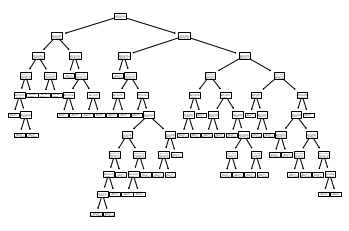

In [10]:
tree.plot_tree(reg_var.estimators_[0])
plt.show()

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

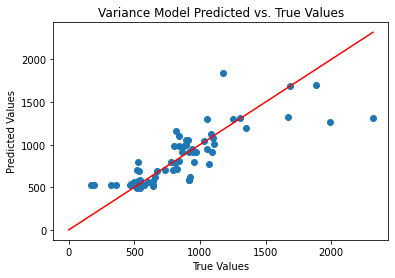

In [11]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

## Discharge Model Features

In [12]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_dis = RandomForestRegressor().fit(X_train_dis,np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Random forest with discharge model features")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mape_train_dis)
print("Mean % Test Error: ", mape_test_dis)

Random forest with discharge model features
Training RMSE:  80.76957917559702
Test RMSE:  206.77138626492888
Mean % Train Error:  0.04973204873854851
Mean % Test Error:  0.20103890847170525


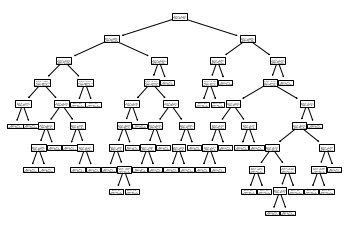

In [13]:
# sample decision tree
tree.plot_tree(reg_dis.estimators_[0])
plt.show()

In [14]:
reg_dis.feature_importances_

array([0.56705885, 0.22830879, 0.03791119, 0.02872816, 0.03121274,
       0.10678027])

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN)')

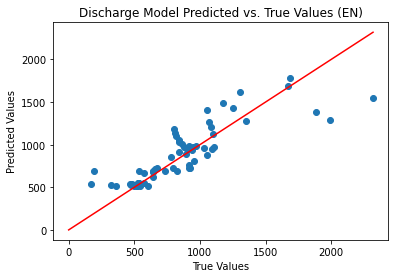

In [15]:
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN)")

## Full model features

In [16]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

reg_full = RandomForestRegressor().fit(X_train_full,np.ravel(y_train))

y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Random Forest with Full model features")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Random Forest with Full model features
Training RMSE:  74.64794715766084
Test RMSE:  207.70187767748882
Mean % Train Error:  0.04915804844910791
Mean % Test Error:  0.19775161995559978


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

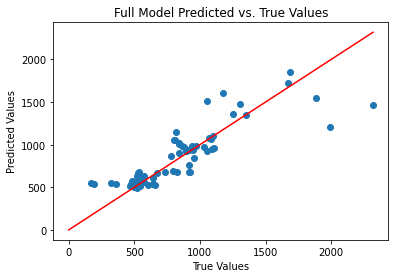

In [17]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [18]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Train RMSE": [rmse_train_var,
                                              rmse_train_dis,
                                              rmse_train_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'Old Data Train RMSE Comparison')

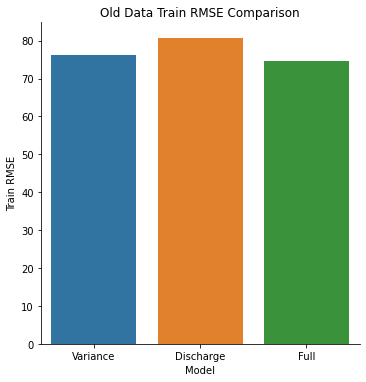

In [19]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Train RMSE")
plt.title("Old Data Train RMSE Comparison")

Text(0.5, 1.0, 'Old Data Test RMSE Comparison')

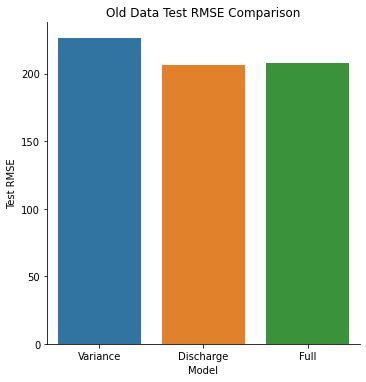

In [20]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Old Data Test RMSE Comparison")

# New Data

In [21]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

new_ct["battery_index"] = new_ct["battery"].str[-2:].astype('int')

new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [22]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

In [23]:
if standardized:
    new_ct_full[all_model_features] = standardize(
        new_ct_full[all_model_features].replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    )

## New Data Variance Model

In [24]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

In [25]:
reg_var = RandomForestRegressor().fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  163.31381873972944
Test RMSE:  415.0406445212765
Mean % Train Error:  0.04174019371706654
Mean % Test Error:  0.09366577319899332


## New Data Discharge Model

In [26]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

reg_dis = RandomForestRegressor().fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  173.36453818467032
Test RMSE:  384.7776581757581
Mean % Train Error:  0.0420118668284604
Mean % Test Error:  0.08592996489222514


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR)')

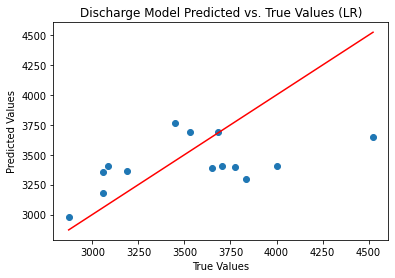

In [27]:
# Random forest discharge features
max_dis = y_test.max()[0]
min_dis = y_test.min()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([min_dis, max_dis], [min_dis, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR)")

## New Data Full Model Features

In [28]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_full.index][[y]]

reg_full = RandomForestRegressor().fit(X_train_full, np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  172.3479925948809
Test RMSE:  411.89362564723535
Mean % Train Error:  0.0445268482454577
Mean % Test Error:  0.09499136559813291


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR)')

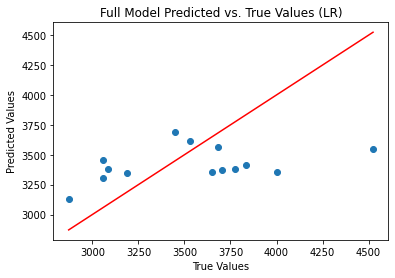

In [29]:
#Linear Regression
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([min_full, max_full], [min_full, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR)")

In [30]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Train RMSE": [rmse_train_var,
                                              rmse_train_dis,
                                              rmse_train_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

Text(0.5, 1.0, 'New Data Train RMSE Comparison')

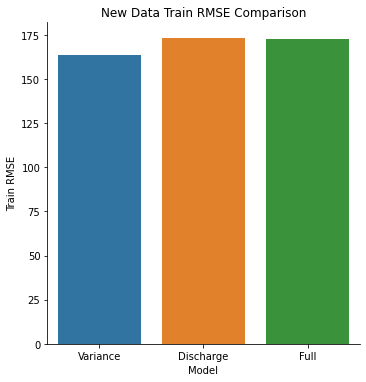

In [31]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Train RMSE")
plt.title("New Data Train RMSE Comparison")

Text(0.5, 1.0, 'New Data Test RMSE Comparison')

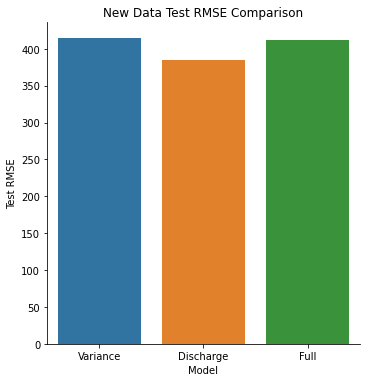

In [32]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("New Data Test RMSE Comparison")

# Old + New Data (Combined)

In [33]:
old_ct["Source"] = -1
new_ct_full["Source"] = 1
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

variance_model_features = [variance_model_features, "Source"]
discharge_model_features.append("Source")
full_model_features.append("Source")

In [34]:
if train_old_test_new:
    train_ind = [i for i in range(1,83)]
    test_ind = [j for j in range(139,168)]
    
else:
    train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
            35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
            69, 71, 73, 75, 77, 79, 81]
    test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
            34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
            68, 70, 72, 74, 76, 78, 80, 82, 83]

    train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
    test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

## Combined Data Variance Model

In [35]:
# Variance model
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.iloc[X_test_var.index][[y]]

# log transformation
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [36]:
reg_var = RandomForestRegressor().fit(X_train_var, np.ravel(y_train))
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

# if log_transformation:
#     y_train = np.exp(y_train)
#     y_test = np.exp(y_test)
#     y_pred_train_var = np.exp(y_pred_train_var)
#     y_pred_test_var = np.exp(y_pred_test_var)

rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  164.86819056740188
Test RMSE:  322.809829039124
Mean % Train Error:  0.08753061691653662
Mean % Test Error:  0.1513840251626355


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values')

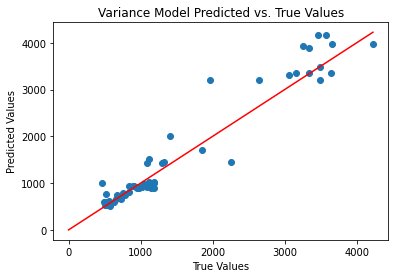

In [37]:
# Variance model
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values")

## Combined Data Discharge Model

In [38]:
full_data.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan).isna().sum()

X.abs_min_discharge_capacity_difference_cycles_2:100         1
X.abs_variance_discharge_capacity_difference_cycles_2:100    1
X.abs_skew_discharge_capacity_difference_cycles_2:100        1
X.abs_kurtosis_discharge_capacity_difference_cycles_2:100    1
X.discharge_capacity_cycle_2                                 1
X.max_discharge_capacity_difference                          1
Source                                                       0
dtype: int64

In [39]:
# discharge model
X_train_dis = full_data.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_train_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis = full_data.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_test_dis.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.iloc[X_test_dis.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
reg_dis = RandomForestRegressor().fit(X_train_dis, np.ravel(y_train))
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

# if log_transformation:
#     y_train = np.exp(y_train)
#     y_test = np.exp(y_test)
#     y_pred_train_dis = np.exp(y_pred_train_dis)
#     y_pred_test_dis = np.exp(y_pred_test_dis)
    
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)

print("Discharge Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Training RMSE:  118.69358561578923
Test RMSE:  315.37870733107775
Mean % Train Error:  0.07091752509176913
Mean % Test Error:  0.13767203550513565


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values')

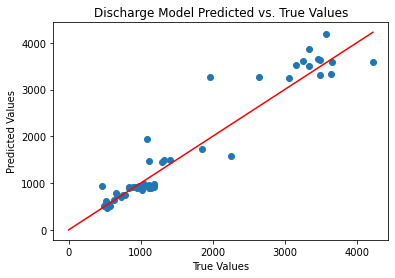

In [40]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values")

## Combined Data Full Model

In [41]:
# full model
X_train_full = full_data.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_train_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_train = full_data.loc[X_train_full.index][[y]]

X_test_full = full_data.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan).dropna(axis=0)
X_test_full.dropna(axis=0, inplace=True) #Can delete if we find a solution to the issue presented above
y_test = full_data.loc[X_test_full.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

reg_full = RandomForestRegressor().fit(X_train_full, np.ravel(y_train))
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)

print("Full Basic Linear Regression Model")
print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Training RMSE:  127.37085823621015
Test RMSE:  308.489508949493
Mean % Train Error:  0.06650249844506101
Mean % Test Error:  0.13674456923614792


Text(0.5, 1.0, 'Full Model Predicted vs. True Values')

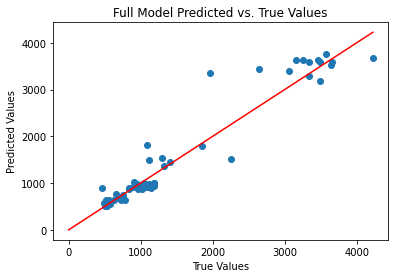

In [42]:
min_full = y_test.min()[0]
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values")

In [43]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model": ["Variance",
                                         "Discharge",
                                         "Full"],
                                        
                               "Train RMSE": [rmse_train_var,
                                              rmse_train_dis,
                                              rmse_train_full],
                               
                               "Test RMSE": [rmse_test_var,
                                             rmse_test_dis,
                                             rmse_test_full]})#,

In [44]:
all_data_metrics

,Model,Train RMSE,Test RMSE
0,Variance,164.868191,322.809829
1,Discharge,118.693586,315.378707
2,Full,127.370858,308.489509


Text(0.5, 1.0, 'Combined Data Train RMSE Comparison')

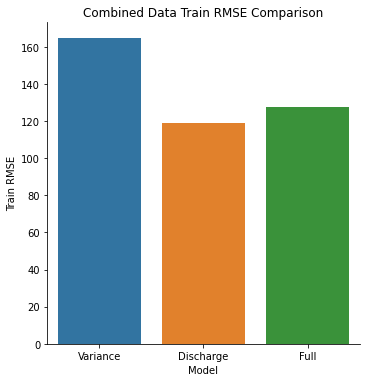

In [45]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Train RMSE")
plt.title("Combined Data Train RMSE Comparison")

Text(0.5, 1.0, 'Combined Data Test RMSE Comparison')

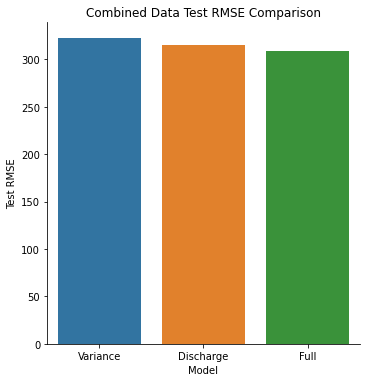

In [46]:
sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = "Test RMSE")
plt.title("Combined Data Test RMSE Comparison")